In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deep-learning-spring-2025-project-2/test_unlabelled.pkl


In [2]:
# -----------------------------
# 1. Import libraries
# -----------------------------
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import pickle

# -----------------------------
# 2. Use GPU if available
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -----------------------------
# 3. Load and preprocess AGNEWS dataset
# -----------------------------
dataset = load_dataset("ag_news")
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


Using device: cuda


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

# EDA and Data Filtering

In [3]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})


In [4]:
# Display a couple of samples from the raw training dataset
train_dataset = dataset["train"]
few_examples = train_dataset[:4]
print(few_examples)

{'text': ["Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.', "Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\\about the economy and the outlook for earnings are expected to\\hang over the stock market next week during the depth of the\\summer doldrums.", 'Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\\flows from the main pipeline in southern Iraq after\\intelligence showed a rebel militia could strike\\infrastructure, an oil official said on Saturday.'], 'label': [2, 2, 2, 2]}


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


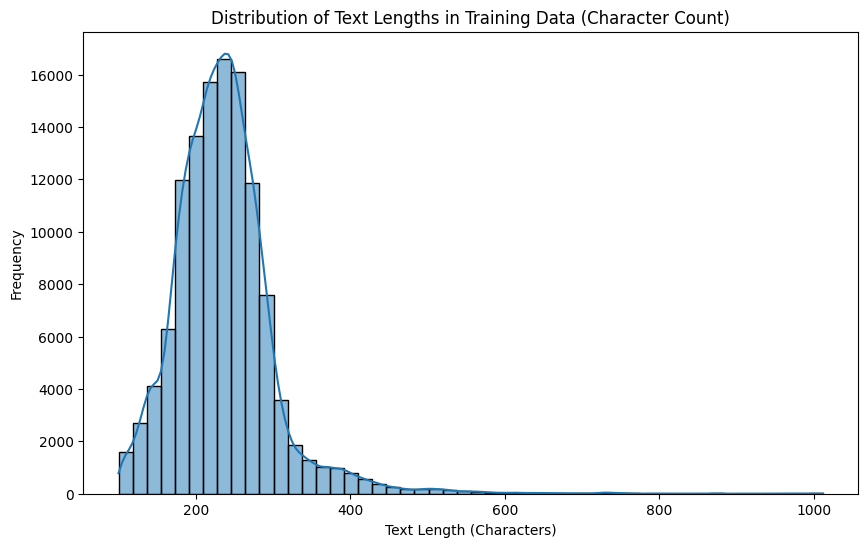

In [5]:
# Plot the distribution of text lengths in the training data
import matplotlib.pyplot as plt
import seaborn as sns

text_lengths = [len(example['text']) for example in train_dataset]

plt.figure(figsize=(10, 6))
sns.histplot(text_lengths, bins=50, kde=True)
plt.title('Distribution of Text Lengths in Training Data (Character Count)')
plt.xlabel('Text Length (Characters)')
plt.ylabel('Frequency')
plt.show()

Filter:   0%|          | 0/120000 [00:00<?, ? examples/s]


--- Original training dataset size: 120000 ---
--- Filtered training dataset size: 119695 ---


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


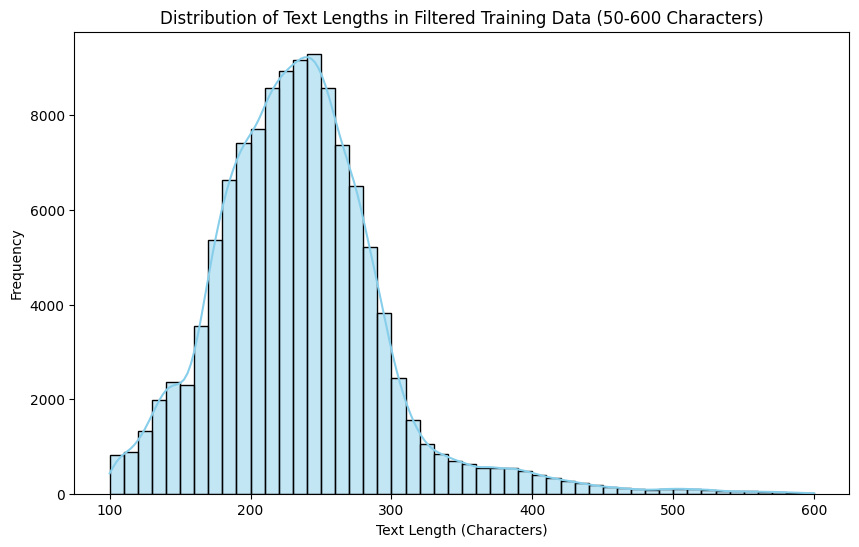

In [6]:
# -----------------------------
# Filter training data based on text length
# -----------------------------
min_length = 50  # minimum character length
max_length = 600 # maximum character length

filtered_train_dataset = train_dataset.filter(
    lambda example: min_length <= len(example['text']) <= max_length
)

print(f"\n--- Original training dataset size: {len(train_dataset)} ---")
print(f"--- Filtered training dataset size: {len(filtered_train_dataset)} ---")

# Let's take a look at the length distribution of the filtered dataset
filtered_text_lengths = [len(example['text']) for example in filtered_train_dataset]

plt.figure(figsize=(10, 6))
sns.histplot(filtered_text_lengths, bins=50, kde=True, color='skyblue')
plt.title(f'Distribution of Text Lengths in Filtered Training Data ({min_length}-{max_length} Characters)')
plt.xlabel('Text Length (Characters)')
plt.ylabel('Frequency')
plt.show()

In [7]:
# Tokenize the filtered training dataset
tokenized_filtered_dataset = filtered_train_dataset.map(tokenize_function, batched=True)
tokenized_filtered_dataset = tokenized_filtered_dataset.rename_column("label", "labels")
tokenized_filtered_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/119695 [00:00<?, ? examples/s]

In [8]:
# -----------------------------
# 4. Load RoBERTa model with LoRA adapters
# -----------------------------
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=4)

lora_config = LoraConfig(
    # r=8, # base
    # lora_alpha=32, # base
    r=2, 
    lora_alpha=2,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS
)

model = get_peft_model(model, lora_config)
model.to(device)
model.print_trainable_parameters()

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 667,396 || all params: 125,316,104 || trainable%: 0.5326


In [9]:
# -----------------------------
# 5. Define training arguments
# -----------------------------
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="no",
    learning_rate=2e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    report_to="none"
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [10]:
# -----------------------------
# 6. Train the model
# -----------------------------
trainer = Trainer(
    model=model,
    args=training_args,
    # train_dataset=tokenized_dataset["train"],
    train_dataset=tokenized_filtered_dataset,
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()
# trainer.to(device)

<ipython-input-10-509d6db76992>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.224300,0.203161,0.934079
2,0.189500,0.188821,0.935658
3,0.181600,0.185804,0.938026


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=11223, training_loss=0.21629695455562534, metrics={'train_runtime': 4145.4653, 'train_samples_per_second': 86.621, 'train_steps_per_second': 2.707, 'total_flos': 2.380428512750592e+16, 'train_loss': 0.21629695455562534, 'epoch': 3.0})

In [11]:
# After trainer.train() is finished
output_model_path = "./trained_lora_model"
model.save_pretrained(output_model_path)
tokenizer.save_pretrained(output_model_path) 

('./trained_lora_model/tokenizer_config.json',
 './trained_lora_model/special_tokens_map.json',
 './trained_lora_model/vocab.json',
 './trained_lora_model/merges.txt',
 './trained_lora_model/added_tokens.json',
 './trained_lora_model/tokenizer.json')

In [12]:
# -----------------------------
# 7. Evaluate the model
# -----------------------------
eval_results = trainer.evaluate()
print("Final Evaluation Accuracy:", eval_results["eval_accuracy"])

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Final Evaluation Accuracy: 0.9380263157894737


In [13]:
# -----------------------------
# 8. Check trainable parameter count
# -----------------------------
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

Trainable parameters: 667396


In [14]:
from datasets import Dataset
from torch.utils.data import DataLoader

# Load dataset object
with open("/kaggle/input/deep-learning-spring-2025-project-2/test_unlabelled.pkl", "rb") as f:
    test_dataset = pickle.load(f)

# Convert to HuggingFace Dataset (already is, but this helps formatting)
test_dataset = Dataset.from_dict({"text": test_dataset["text"]})

# Tokenize function
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

# Apply tokenizer
tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True)
tokenized_test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])

# Create PyTorch DataLoader for batching
test_dataloader = DataLoader(tokenized_test_dataset, batch_size=64)

# Prediction loop
model.eval()
all_predictions = []

with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=-1)
        all_predictions.extend(preds.cpu().numpy())


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

In [15]:
# -----------------------------
# 10. Save predictions to CSV
# -----------------------------
df = pd.DataFrame({
    "ID": list(range(len(all_predictions))),   # ID ✅
    "label": all_predictions
})
df.to_csv("submission_v13.csv", index=False)
print("✅ Batched predictions complete. Saved to submission_v13.csv.")

✅ Batched predictions complete. Saved to submission_v13.csv.
